# Red Inicial


## Imports


In [1]:
from __future__ import annotations

import os
from abc import ABC, abstractmethod
from collections import deque
from enum import Enum
from functools import cache
from itertools import product
from time import perf_counter, time
from typing import Any, Generator, Optional, override

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rich
import tqdm
from gymnasium.spaces import Box, Dict, Discrete, Tuple
from gymnasium.utils import seeding
from gymnasium.utils.env_checker import check_env
from matplotlib.ticker import MaxNLocator
from pandas import DataFrame, Series
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [2]:
name = "Example"

## Clases y Funciones


In [3]:
class Packet_Generator():
    sizes: list[tuple[int, int]] = [
        (64, 128),
        (128, 256),
        (256, 1024),
        (1024, 1500)]
    probs: list[float] = [0.5,
                          0.2,
                          0.15,
                          0.15]
    
    def __init__(self, min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_rate=4, max_rate=24, # Paquetes/segundo
                 seed=None,
                 step_dur=1e-3 # En segundos
                 ):
        
        assert np.sum(self.probs) == 1
        assert len(self.sizes) == len(self.probs)
        assert min_rate <= max_rate
        
        self._np_random, _ = seeding.np_random(seed)
        indice: int = self._np_random.choice(len(self.sizes), p=self.probs)

        min_size, max_size = self.sizes[indice]
        self.step_dur: float = step_dur

        self.packet = Dict({
            "IP":       Box(low=min_ip, high=max_ip, shape=(), dtype=int,
                            seed=self._np_random),
            "PORT":     Box(low=min_port, high=max_port, shape=(), dtype=int,
                            seed=self._np_random),
            "PROTOCOL": Box(low=min_protocol, high=max_protocol, shape=(), dtype=int,
                            seed=self._np_random),
            "SIZE":     Box(low=min_size, high=max_size, shape=(), dtype=int,
                            seed=self._np_random)  # En bytes
        })
        
        self.min_rate: float = min_rate*step_dur
        self.max_rate: float = max_rate*step_dur
        #print(min_rate,max_rate,self.min_rate,self.max_rate)

    def generate_packet(self) -> dict[str, int]:
        return self.packet.sample()

    def generate_packets(self) -> list[dict[str, int]]:
        # Como el rate sería por segundo habría que transformarlo a la unidad deseada
        if self.min_rate < 1:
            al: float = self._np_random.random()
            rate_al: float = self._np_random.uniform(
                self.min_rate, self.max_rate)
            if al <= rate_al:
                num_packets: int = 1
            else:
                return []
        else:
            min_rate = np.floor(self.min_rate)
            max_rate = np.ceil(self.max_rate)
            num_packets: int = self._np_random.integers(
                min_rate, max_rate,endpoint=True) # Incluye tanto el limite minimo y maximo

        return [self.generate_packet() for _ in range(num_packets)]



class DOS_Packet_Generator(Packet_Generator):
    sizes: list[tuple[int, int]] = [(64, 128),
                                    (128, 256),
                                    (256, 1024),
                                    (1024, 1500)]
    probs: list[float] = [0.8,
                          0.15,
                          0.03,
                          0.02]
    def __init__(self,
                 min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_rate=10_000, max_rate=10_300,
                 seed=None,
                 step_dur=1e-3 # En segundos
                 ):
        ip: int = np.random.default_rng(seed).integers(min_ip, max_ip)
        super().__init__(ip, ip,
                         min_port, max_port,
                         min_protocol, max_protocol,
                         min_rate, max_rate,
                         seed,
                         step_dur
                         )


class DDOS_Packet_Generator(Packet_Generator):
    def __init__(self,
                 min_ip=0, max_ip=2000,
                 min_port=0, max_port=4000,
                 min_protocol=0, max_protocol=100,
                 min_size=5, max_size=15,
                 min_rate=2, max_rate=10):
        raise NotImplementedError("DDOS Packet Generator not implemented")
        super().__init__(min_ip, max_ip,
                         min_port, max_port,
                         min_protocol, max_protocol,
                         min_size, max_size,
                         min_rate, max_rate)

class MaquinaDeEstados:
    def __init__(self, generador: np.random.Generator = seeding.np_random(seed=None)[0]):
        self.estado: Estado = EstadoNormal
        self.estados_posibles: tuple[type[Estado]] = (
            EstadoNormal, 
            EstadoAtaque)
        self.registro_estados: list[Estado] = []
        self._np_random= generador
        self.normal = Packet_Generator(seed=None)
        self.DoS = DOS_Packet_Generator(seed=None)

    def get_random(self):
        return self._np_random.random()
    def get_estado(self):
        return self.estado

    def get_random_choice(self, choices):
        return self._np_random.choice(choices)

    def cambiar_estado(self):
        self.estado.cambiar(self)
        self.registro_estados.append(self.estado.__name__)
    def generate_packets(self):
        if self.estado == EstadoNormal:
            paquetes = self.normal.generate_packets()
        else:
            paquetes = self.DoS.generate_packets()
        return paquetes


class Estado(ABC):
    @classmethod
    @abstractmethod
    def cambiar(cls, maquina: MaquinaDeEstados):
        """Método de clase que cambiará el estado"""
        if maquina.get_random() < cls.probCambiar():
            # Elegir aleatoriamente un nuevo estado diferente al actual
            new_state: Estado = maquina.get_random_choice(
                cls.get_estados_posibles(maquina.estados_posibles))
            maquina.estado = new_state

    @classmethod
    @abstractmethod
    def probCambiar(cls) -> float:
        """Método de clase que devuelve la probabilidad de cambio de estado"""
        pass

    @classmethod
    @abstractmethod
    @cache
    def get_estados_posibles(cls, estados) -> list[Estado]:
        """Método de clase que devuelve los estados posibles"""
        return list(set(estados).difference({cls}))


class EstadoNormal(Estado):
    @classmethod
    @override
    def probCambiar(cls):
        return 0.1


class EstadoAtaque(Estado):
    @classmethod
    @override
    def probCambiar(cls):
        return 0.05
    


class PacketAttack(Enum):
    @staticmethod
    def new_set(description, weight, class_ref):
        return {
            "Description": description,
            "weight": weight,
            "class": class_ref
        }

    @staticmethod
    def not_implemented():
        raise NotImplementedError(f"Class not implemented")
    @classmethod
    @cache
    def weights(cls):
        attack_weights = []
        for attack in PacketAttack:
            attack_weights.append(attack.value["weight"])
        return np.array(attack_weights)

    # ----ENUM VALUES----
    DOS = new_set("Denial of Service", 1.0, DOS_Packet_Generator)
    DDOS = new_set("Distributed Denial of Service", 2.0, DDOS_Packet_Generator)


gen = DOS_Packet_Generator(step_dur=1e-6,seed=1)




print(len(gen.generate_packets()))

0


In [4]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones

def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun


In [122]:
class RouterEnv(gym.Env):
    total_time: float = 400.0  # Num steps

    def __init__(self, max_len=250, seed: Optional[int] = None):

        super(RouterEnv, self).__init__()
        if max_len < 1:
            raise ValueError("max_len must be greater than 0")

        self.max_len: int = max_len

        duraction_step: float = 1.0  
        duraction_step *= 1e-3  # En segundos
        velocidad_procesamiento: float = 5e6/8 # bytes por segundo de procesamiento
        self.rate: float = velocidad_procesamiento*duraction_step  # bytes por step de procesamiento
        #self.attack_probability = 0.8
        self.ocupacion_limite = 0.8

        self._set_initial_values(seed)
        # TODO mirar el espacio de observacion y limitar cada uno de los valores
        
        self.observation_space = Box(low=0, high=1, dtype=np.float32) # Ocupacion cola
                                      

        self.action_space = Discrete(len(Acciones))

    def _set_initial_values(self, seed):
        self.queue = deque(maxlen=self.max_len)
        # self.step_durations: list[float] = []
        self._np_random, self._np_random_seed = seeding.np_random(seed)
        self.current_action: Acciones = Acciones.PERMITIR
        self.action_count: int = 1
        self.uds_tiempo_pasado: float = 0.0
        self.mb_restantes: float = -1.0

        self.maquina = MaquinaDeEstados(self._np_random)
        

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        self._set_initial_values(seed)

        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def _get_obs(self):
        return np.array([self.get_ocupacion()], dtype=np.float32)

    def _get_info(self):
        #npack, tam_total, ocu_act, *_ = self.calculate_queue_stats()
        npack=len(self.queue)
        return {"Stats": {
           # "Queue": np.array(self.queue),
            "EstadoMaquina": self.maquina.get_estado().__name__,
            "NumPaquetes": npack,
            "TamañoTotal": self.get_tam_ocu(),
            "Action": self.current_action,
            "OcupacionActual": self.get_ocupacion(),
            "LimiteOcupación": self.ocupacion_limite
        }}

    def calculate_queue_stats(self):
        tam_total = 0
        for paquete in self.queue:
            tam_total += int(paquete["SIZE"])
        tam_promedio: float = tam_total / \
            len(self.queue) if len(self.queue) > 0 else 0.0

        num_packets: int = len(self.queue)
        ocu_act: float = self.get_ocupacion()
        
        return np.array([ocu_act], dtype=np.float32)
        return np.array([num_packets, tam_total, ocu_act,
                         Acciones.action_to_int(self.current_action), self.action_count], dtype=np.float32)
    
    def get_tam_ocu(self):
        tam_total = 0.0
        for paquete in self.queue:
            tam_total += float(paquete["SIZE"])
        return tam_total

    def packet_input(self, input: list[dict[str, any]] = None) -> int:
        if input is not None:
            paquetes = input
        else:
            paquetes = self.maquina.generate_packets()
            self.maquina.cambiar_estado()

        if self.current_action == Acciones.DENEGAR:
            return len(paquetes)
        

        if len(self.queue) + len(paquetes) > self.max_len:

            espacio_libre = self.max_len - len(self.queue)
            self.queue.extend(paquetes[:espacio_libre])

            assert len(self.queue) == self.max_len

            return len(paquetes) - (espacio_libre)
        
        self.queue.extend(paquetes)
        return 0  # No se han descartado paquetes
    
    def registrar_accion(self, action: Acciones):
        if action == self.current_action:
            self.action_count += 1
        else:
            self.action_count = 1
            self.current_action = action
            
    @medir_tiempo(0)
    def step(self, action_num: int):

        action: Acciones = Acciones.int_to_action(action_num)
        self.registrar_accion(action)
        
        descartados: int = self.packet_input()
        

        self.procesar_por_tamaño()

        reward: float = self.get_reward(descartados, action)
        observation = self._get_obs()
        # True si se desvía del comportamiento normal para abortar, necesitaría un reset
        truncated = False
        info = self._get_info()

        self.uds_tiempo_pasado += 1
        finished: bool = self._is_finished_execution()

        return observation, reward, finished, truncated, info

    def get_ocupacion(self) -> float:
        return len(self.queue) / self.max_len

    

    @medir_tiempo(0)
    def procesar_por_tamaño(self):

        if len(self.queue) == 0:
            return

        # print(self.queue)
        tam_procesado = 0.0
        # Calcula los mb que faltan por procesar

        if self.mb_restantes == -1 and len(self.queue) > 0:
            paquete = self.queue[0]
            self.mb_restantes = paquete["SIZE"]

        while tam_procesado < self.rate and len(self.queue) > 0:
            if self.mb_restantes == 0:
                p2 = self.queue.popleft()  # Quita el paquete que se ha procesado
                if len(self.queue) == 0:
                    self.mb_restantes == -1
                    break
                # Nuevo paquete
                paquete = self.queue[0]
                assert p2 != paquete
                # Calcula los mb que faltan por procesar
                self.mb_restantes = paquete["SIZE"]
            else:
                # Procesar
                procesado_local: float = min(self.mb_restantes,  # Procesar lo que queda del paquete
                                             self.rate-tam_procesado)  # Procesar lo que queda del paso
                self.mb_restantes -= procesado_local
                tam_procesado += procesado_local

    def _is_finished_execution(self) -> bool:
        # Terminar solo después de 10 pasos
        return self.uds_tiempo_pasado >= self.total_time

    def close(self):
        # Cerrar el entorno, liberar recursos, cerrar conexiones, etc
        return super().close()

    def render(self, mode='human'):
        # Renderizar el entorno
        return super().render(mode=mode)
    
    def get_reward(self, descartados, action: Acciones) -> float:
        reward = 0.0
        # Penaliza por ocupacion
        actual: float = self.get_ocupacion()

        if actual > self.ocupacion_limite:
            factor_penalizacion: float = 4.0
            # Calculamos cuánto se excede la ocupación (normalizado entre 0 y 1)
            exceso: float = (actual - self.ocupacion_limite) / \
                (1 - self.ocupacion_limite)

            # Cuando la ocupación es alta:
            # - Penalizamos fuertemente permitir (valor 1)
            # - Premiaremos denegar (valor -1)
            if action == Acciones.PERMITIR:
                # Penalización base + extra proporcional al exceso
                reward -= factor_penalizacion * (1 + exceso)
            elif action == Acciones.DENEGAR:
                # Premia la acción de denegar: se suma una recompensa que decrece si el exceso es muy alto
                reward -= factor_penalizacion/5 * exceso
            else:
                raise ValueError(f"Unknown action {action}")
        else:
            # Cuando la ocupación es baja (por debajo del umbral):
            # - Premiaremos permitir (acción normal)
            # - Penalizamos denegar, ya que se estaría negando cuando no hace falta
            if action == Acciones.PERMITIR:
                reward += 1.0
            elif action == Acciones.DENEGAR:
                # Aquí se penaliza la acción de denegar.
                # Se usa self.action_count para escalar la penalización, pero puedes ajustar este factor.
                reward -= self.action_count * 0.1
            else:
                raise ValueError(f"Unknown action {action}")


        """if actual > self.ocupacion_limite:
            penalizacion: float = np.power(
                (actual-self.ocupacion_limite)/(1-self.ocupacion_limite), 1)  # Entre 0 y 1
            factor_penalizacion: float = 2
            reward -= penalizacion*factor_penalizacion
            if action.value > 0:
                reward -= factor_penalizacion
        else:
            if action.value >= 0:
                reward += 1
            else:
                reward += -1*self.action_count*1
            """
        # TODO Cuando la recompensa de la accion sea negativa y la cola esta por debajo de cierto umbral penalizar
        return reward
        """
        reward = 0
        mult_ocu=300
        mult_descar=2

        #Penaliza por ocupacion
        actual: float = self.get_ocupacion()
        if actual > self.ocupacion_media:
            penalizacion_ocupacion: float = np.square(
                np.subtract(actual, self.ocupacion_media))*mult_ocu

            reward -= penalizacion_ocupacion
        else:
            reward += 20
            
        #Penaliza por descartados
        reward -= descartados*mult_descar

        if action.value >= 0:
            reward += action.value  # recompensa si la acción tiene recompensa positiva
        else:
            # penalizar si la acción tiene recompensa negativa y se repite varias veces
            reward += action.value*self.action_count
        """
    
    def prueba(self):
        return
        reward = 0.0
        # Penaliza por ocupacion
        actual: float = self.get_ocupacion()
        if actual > self.ocupacion_limite:
            min_pen = 0.3
            max_pen = 2
            reward -= (actual - self.ocupacion_limite) * (max_pen -
                                                         min_pen) / (1 - self.ocupacion_limite) + min_pen
        else:
            reward += 2


class Acciones(Enum):
    PERMITIR = 1
    DENEGAR = -1

    @classmethod
    def int_to_action(cls, action: int) -> "Acciones":
        return cls._get_actions_list()[action]

    @classmethod
    @cache
    def _get_actions_list(cls) -> list["Acciones"]:
        return list(Acciones)

    @classmethod
    @cache
    def action_to_int(cls, action: "Acciones") -> int:
        return cls._get_actions_list().index(action)

## Entrenamiento

In [123]:
tmp_path = "./train_log/"


env = RouterEnv(seed=None)
check_env(env)

new_logger: Logger = configure(tmp_path, ["stdout", "csv"])
env = Monitor(env, tmp_path)


model:PPO = PPO("MlpPolicy", env, 
                verbose=True)



"""
eval_callback = EvalCallback(
    env,  # Entorno de evaluación
    best_model_save_path="./logs/best_model",  # Ruta para guardar el mejor modelo
    log_path="./logs",  # Ruta para guardar estadísticas
    eval_freq=10000,  # Frecuencia de evaluación (en pasos)
    deterministic=True,
    render=False,
)
, callback=eval_callback
"""
"""
ep_info = a.ep_info_buffer
print(a.ep_info_buffer)
if ep_info is not None and len(ep_info) > 0:
    rew=ep_info[0]["r"]
    print(rew)
    saved= PPO.load("Example")
    print(ep_info.pop())
"""


model.set_logger(new_logger)
model.learn(total_timesteps=int(1e5),
            progress_bar=True)


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Logging to ./train_log/


Output()

Using cpu device
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | 154      |
| time/              |          |
|    fps             | 518      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 26.1       |
| time/                   |            |
|    fps                  | 473        |
|    iterations           | 2          |
|    time_elapsed         | 8          |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.02063357 |
|    clip_fraction        | 0.351      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.677     |
|    explained_variance   | -0.00514   |
|    learning_rate        | 0.0003     |
|    loss                 | 2.1        |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 18.6       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 72.1         |
| time/                   |              |
|    fps                  | 452          |
|    iterations           | 3            |
|    time_elapsed         | 13           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 8.219997e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.671       |
|    explained_variance   | -0.00907     |
|    learning_rate        | 0.0003       |
|    loss                 | 208          |
|    n_updates            | 20           |
|    policy_gradient_loss | 0.000246     |
|    value_loss           | 598          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 29.7          |
| time/                   |               |
|    fps                  | 444           |
|    iterations           | 4             |
|    time_elapsed         | 18            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00058221683 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.671        |
|    explained_variance   | 0.503         |
|    learning_rate        | 0.0003        |
|    loss                 | 12.9          |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.00151      |
|    value_loss           | 80.5          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 67.3         |
| time/                   |              |
|    fps                  | 436          |
|    iterations           | 5            |
|    time_elapsed         | 23           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0038205197 |
|    clip_fraction        | 0.00127      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.675       |
|    explained_variance   | 0.543        |
|    learning_rate        | 0.0003       |
|    loss                 | 248          |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00433     |
|    value_loss           | 503          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 96.9        |
| time/                   |             |
|    fps                  | 433         |
|    iterations           | 6           |
|    time_elapsed         | 28          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.015402898 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.635      |
|    explained_variance   | -0.124      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.58        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0115     |
|    value_loss           | 20.5        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 123         |
| time/                   |             |
|    fps                  | 427         |
|    iterations           | 7           |
|    time_elapsed         | 33          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.010931248 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.583      |
|    explained_variance   | -0.00841    |
|    learning_rate        | 0.0003      |
|    loss                 | 8.59        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.00812    |
|    value_loss           | 27.3        |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 56.6          |
| time/                   |               |
|    fps                  | 427           |
|    iterations           | 8             |
|    time_elapsed         | 38            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 0.00015550829 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.578        |
|    explained_variance   | 0.636         |
|    learning_rate        | 0.0003        |
|    loss                 | 181           |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.000306     |
|    value_loss           | 375           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 86.4         |
| time/                   |              |
|    fps                  | 417          |
|    iterations           | 9            |
|    time_elapsed         | 44           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0019260257 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.592       |
|    explained_variance   | 0.704        |
|    learning_rate        | 0.0003       |
|    loss                 | 965          |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00203     |
|    value_loss           | 1.21e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 107          |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 10           |
|    time_elapsed         | 50           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0053628683 |
|    clip_fraction        | 0.00918      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.56        |
|    explained_variance   | 0.139        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.8         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 59.1         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 82.9          |
| time/                   |               |
|    fps                  | 405           |
|    iterations           | 11            |
|    time_elapsed         | 55            |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 0.00075912726 |
|    clip_fraction        | 0.00122       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.555        |
|    explained_variance   | 0.18          |
|    learning_rate        | 0.0003        |
|    loss                 | 27.8          |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.00118      |
|    value_loss           | 54.7          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 71.6         |
| time/                   |              |
|    fps                  | 407          |
|    iterations           | 12           |
|    time_elapsed         | 60           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0062358845 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.594       |
|    explained_variance   | 0.837        |
|    learning_rate        | 0.0003       |
|    loss                 | 186          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00452     |
|    value_loss           | 487          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 73.7         |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 13           |
|    time_elapsed         | 65           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0038168235 |
|    clip_fraction        | 0.00649      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.58        |
|    explained_variance   | 0.885        |
|    learning_rate        | 0.0003       |
|    loss                 | 199          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00287     |
|    value_loss           | 434          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 88.1        |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 14          |
|    time_elapsed         | 70          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.003323823 |
|    clip_fraction        | 0.0193      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.571      |
|    explained_variance   | 0.92        |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.00619    |
|    value_loss           | 221         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 89.9         |
| time/                   |              |
|    fps                  | 409          |
|    iterations           | 15           |
|    time_elapsed         | 75           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0072606215 |
|    clip_fraction        | 0.0543       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | 0.746        |
|    learning_rate        | 0.0003       |
|    loss                 | 75.3         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00428     |
|    value_loss           | 142          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 101          |
| time/                   |              |
|    fps                  | 408          |
|    iterations           | 16           |
|    time_elapsed         | 80           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0012559935 |
|    clip_fraction        | 0.00635      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.536       |
|    explained_variance   | 0.941        |
|    learning_rate        | 0.0003       |
|    loss                 | 69           |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 121          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 113          |
| time/                   |              |
|    fps                  | 407          |
|    iterations           | 17           |
|    time_elapsed         | 85           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0052805934 |
|    clip_fraction        | 0.0779       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.515       |
|    explained_variance   | 0.0552       |
|    learning_rate        | 0.0003       |
|    loss                 | 102          |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00359     |
|    value_loss           | 73.5         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 121         |
| time/                   |             |
|    fps                  | 408         |
|    iterations           | 18          |
|    time_elapsed         | 90          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.008075524 |
|    clip_fraction        | 0.0442      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.517      |
|    explained_variance   | 0.644       |
|    learning_rate        | 0.0003      |
|    loss                 | 69.5        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00262    |
|    value_loss           | 86.2        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 129         |
| time/                   |             |
|    fps                  | 409         |
|    iterations           | 19          |
|    time_elapsed         | 95          |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.005756361 |
|    clip_fraction        | 0.0549      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.511      |
|    explained_variance   | 0.66        |
|    learning_rate        | 0.0003      |
|    loss                 | 26          |
|    n_updates            | 180         |
|    policy_gradient_loss | -0.00396    |
|    value_loss           | 86.6        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 137          |
| time/                   |              |
|    fps                  | 409          |
|    iterations           | 20           |
|    time_elapsed         | 99           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0013036694 |
|    clip_fraction        | 0.0101       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.514       |
|    explained_variance   | 0.613        |
|    learning_rate        | 0.0003       |
|    loss                 | 28.7         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.000633    |
|    value_loss           | 61.5         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 144          |
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 21           |
|    time_elapsed         | 104          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0013153874 |
|    clip_fraction        | 0.00811      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.483       |
|    explained_variance   | 0.239        |
|    learning_rate        | 0.0003       |
|    loss                 | 46.3         |
|    n_updates            | 200          |
|    policy_gradient_loss | -1.41e-05    |
|    value_loss           | 69.1         |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 162        |
| time/                   |            |
|    fps                  | 412        |
|    iterations           | 22         |
|    time_elapsed         | 109        |
|    total_timesteps      | 45056      |
| train/                  |            |
|    approx_kl            | 0.00379353 |
|    clip_fraction        | 0.0255     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.51      |
|    explained_variance   | 0.492      |
|    learning_rate        | 0.0003     |
|    loss                 | 17.6       |
|    n_updates            | 210        |
|    policy_gradient_loss | -0.00236   |
|    value_loss           | 62.6       |
----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 184        |
| time/                   |            |
|    fps                  | 412        |
|    iterations           | 23         |
|    time_elapsed         | 114        |
|    total_timesteps      | 47104      |
| train/                  |            |
|    approx_kl            | 0.00446762 |
|    clip_fraction        | 0.0359     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.485     |
|    explained_variance   | 0.403      |
|    learning_rate        | 0.0003     |
|    loss                 | 30.9       |
|    n_updates            | 220        |
|    policy_gradient_loss | -0.00231   |
|    value_loss           | 85.8       |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 189          |
| time/                   |              |
|    fps                  | 412          |
|    iterations           | 24           |
|    time_elapsed         | 119          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0033601972 |
|    clip_fraction        | 0.00894      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.463       |
|    explained_variance   | 0.197        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.2         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.000373    |
|    value_loss           | 73.5         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 194         |
| time/                   |             |
|    fps                  | 413         |
|    iterations           | 25          |
|    time_elapsed         | 123         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.003834752 |
|    clip_fraction        | 0.0501      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.38       |
|    explained_variance   | 0.137       |
|    learning_rate        | 0.0003      |
|    loss                 | 6.68        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00156    |
|    value_loss           | 73.8        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 197          |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 26           |
|    time_elapsed         | 128          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0026766455 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.413       |
|    explained_variance   | 0.443        |
|    learning_rate        | 0.0003       |
|    loss                 | 44.2         |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 80.7         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 210          |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 27           |
|    time_elapsed         | 133          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0028593368 |
|    clip_fraction        | 0.0194       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.388       |
|    explained_variance   | 0.165        |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00273     |
|    value_loss           | 78.9         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 228          |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 28           |
|    time_elapsed         | 138          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0022380191 |
|    clip_fraction        | 0.0202       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.449       |
|    explained_variance   | 0.432        |
|    learning_rate        | 0.0003       |
|    loss                 | 55.9         |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.000191    |
|    value_loss           | 76           |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 227           |
| time/                   |               |
|    fps                  | 415           |
|    iterations           | 29            |
|    time_elapsed         | 142           |
|    total_timesteps      | 59392         |
| train/                  |               |
|    approx_kl            | 0.00064586365 |
|    clip_fraction        | 0.00107       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.439        |
|    explained_variance   | 0.684         |
|    learning_rate        | 0.0003        |
|    loss                 | 23.8          |
|    n_updates            | 280           |
|    policy_gradient_loss | 0.00012       |
|    value_loss           | 85.7          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 229          |
| time/                   |              |
|    fps                  | 415          |
|    iterations           | 30           |
|    time_elapsed         | 147          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0005117352 |
|    clip_fraction        | 0.00786      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.415       |
|    explained_variance   | 0.36         |
|    learning_rate        | 0.0003       |
|    loss                 | 43.5         |
|    n_updates            | 290          |
|    policy_gradient_loss | 2.28e-05     |
|    value_loss           | 91.4         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 264           |
| time/                   |               |
|    fps                  | 415           |
|    iterations           | 31            |
|    time_elapsed         | 152           |
|    total_timesteps      | 63488         |
| train/                  |               |
|    approx_kl            | 0.00072144147 |
|    clip_fraction        | 0.00337       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.351        |
|    explained_variance   | 0.0648        |
|    learning_rate        | 0.0003        |
|    loss                 | 42.8          |
|    n_updates            | 300           |
|    policy_gradient_loss | -0.000257     |
|    value_loss           | 81.8          |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 268         |
| time/                   |             |
|    fps                  | 416         |
|    iterations           | 32          |
|    time_elapsed         | 157         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.006892617 |
|    clip_fraction        | 0.0478      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.417      |
|    explained_variance   | 0.653       |
|    learning_rate        | 0.0003      |
|    loss                 | 67.6        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00185    |
|    value_loss           | 117         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 267         |
| time/                   |             |
|    fps                  | 417         |
|    iterations           | 33          |
|    time_elapsed         | 161         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.003428309 |
|    clip_fraction        | 0.016       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.375      |
|    explained_variance   | 0.784       |
|    learning_rate        | 0.0003      |
|    loss                 | 70.9        |
|    n_updates            | 320         |
|    policy_gradient_loss | 0.000497    |
|    value_loss           | 81.4        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 276          |
| time/                   |              |
|    fps                  | 418          |
|    iterations           | 34           |
|    time_elapsed         | 166          |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0063617947 |
|    clip_fraction        | 0.03         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.4         |
|    explained_variance   | 0.879        |
|    learning_rate        | 0.0003       |
|    loss                 | 30           |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.000588    |
|    value_loss           | 79.9         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 277           |
| time/                   |               |
|    fps                  | 418           |
|    iterations           | 35            |
|    time_elapsed         | 171           |
|    total_timesteps      | 71680         |
| train/                  |               |
|    approx_kl            | 0.00095889985 |
|    clip_fraction        | 0.00845       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.412        |
|    explained_variance   | 0.568         |
|    learning_rate        | 0.0003        |
|    loss                 | 75.5          |
|    n_updates            | 340           |
|    policy_gradient_loss | -0.000327     |
|    value_loss           | 117           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 281          |
| time/                   |              |
|    fps                  | 419          |
|    iterations           | 36           |
|    time_elapsed         | 175          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0027498533 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.395       |
|    explained_variance   | 0.469        |
|    learning_rate        | 0.0003       |
|    loss                 | 15.2         |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.000944    |
|    value_loss           | 88           |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 281         |
| time/                   |             |
|    fps                  | 419         |
|    iterations           | 37          |
|    time_elapsed         | 180         |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.002378311 |
|    clip_fraction        | 0.0103      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.13        |
|    learning_rate        | 0.0003      |
|    loss                 | 37.1        |
|    n_updates            | 360         |
|    policy_gradient_loss | 0.000108    |
|    value_loss           | 85.6        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 280         |
| time/                   |             |
|    fps                  | 418         |
|    iterations           | 38          |
|    time_elapsed         | 185         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.005341269 |
|    clip_fraction        | 0.0116      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.366      |
|    explained_variance   | 0.504       |
|    learning_rate        | 0.0003      |
|    loss                 | 86.3        |
|    n_updates            | 370         |
|    policy_gradient_loss | 0.000165    |
|    value_loss           | 87.9        |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 279         |
| time/                   |             |
|    fps                  | 418         |
|    iterations           | 39          |
|    time_elapsed         | 190         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.003224243 |
|    clip_fraction        | 0.0216      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.368      |
|    explained_variance   | 0.797       |
|    learning_rate        | 0.0003      |
|    loss                 | 19.4        |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00199    |
|    value_loss           | 91.8        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 278          |
| time/                   |              |
|    fps                  | 419          |
|    iterations           | 40           |
|    time_elapsed         | 195          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0012677016 |
|    clip_fraction        | 0.0063       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.38        |
|    explained_variance   | 0.786        |
|    learning_rate        | 0.0003       |
|    loss                 | 37.1         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.000196    |
|    value_loss           | 79.8         |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 280           |
| time/                   |               |
|    fps                  | 419           |
|    iterations           | 41            |
|    time_elapsed         | 200           |
|    total_timesteps      | 83968         |
| train/                  |               |
|    approx_kl            | 0.00055787247 |
|    clip_fraction        | 0.0187        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.339        |
|    explained_variance   | 0.381         |
|    learning_rate        | 0.0003        |
|    loss                 | 36.1          |
|    n_updates            | 400           |
|    policy_gradient_loss | 5.9e-05       |
|    value_loss           | 96.9          |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 272          |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 42           |
|    time_elapsed         | 204          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0017757942 |
|    clip_fraction        | 0.0343       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.33        |
|    explained_variance   | 0.383        |
|    learning_rate        | 0.0003       |
|    loss                 | 31.5         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.0021      |
|    value_loss           | 96           |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 272          |
| time/                   |              |
|    fps                  | 419          |
|    iterations           | 43           |
|    time_elapsed         | 209          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0018724118 |
|    clip_fraction        | 0.00679      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.402       |
|    explained_variance   | 0.739        |
|    learning_rate        | 0.0003       |
|    loss                 | 59.2         |
|    n_updates            | 420          |
|    policy_gradient_loss | 3.65e-05     |
|    value_loss           | 119          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 272          |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 44           |
|    time_elapsed         | 214          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0049953493 |
|    clip_fraction        | 0.0867       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.414       |
|    explained_variance   | 0.519        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.4         |
|    n_updates            | 430          |
|    policy_gradient_loss | -0.00699     |
|    value_loss           | 94           |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 263          |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 45           |
|    time_elapsed         | 219          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0028387464 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.0654       |
|    learning_rate        | 0.0003       |
|    loss                 | 81.4         |
|    n_updates            | 440          |
|    policy_gradient_loss | 9.15e-05     |
|    value_loss           | 91.2         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 262         |
| time/                   |             |
|    fps                  | 421         |
|    iterations           | 46          |
|    time_elapsed         | 223         |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.011122895 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.364      |
|    explained_variance   | 0.493       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.7        |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.00282    |
|    value_loss           | 183         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 265         |
| time/                   |             |
|    fps                  | 421         |
|    iterations           | 47          |
|    time_elapsed         | 228         |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.005467611 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.409      |
|    explained_variance   | 0.219       |
|    learning_rate        | 0.0003      |
|    loss                 | 34.5        |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.00344    |
|    value_loss           | 105         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 268          |
| time/                   |              |
|    fps                  | 421          |
|    iterations           | 48           |
|    time_elapsed         | 232          |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0012411164 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.133        |
|    learning_rate        | 0.0003       |
|    loss                 | 29.9         |
|    n_updates            | 470          |
|    policy_gradient_loss | 0.000969     |
|    value_loss           | 83.2         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 268          |
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 49           |
|    time_elapsed         | 237          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0033059404 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.359       |
|    explained_variance   | 0.606        |
|    learning_rate        | 0.0003       |
|    loss                 | 24.8         |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00152     |
|    value_loss           | 101          |
------------------------------------------


Modelo guardado


### Gráficas de Entrenamiento

['rollout/ep_rew_mean', 'time/total_timesteps', 'rollout/ep_len_mean', 'time/time_elapsed', 'time/iterations', 'time/fps', 'train/clip_range', 'train/entropy_loss', 'train/learning_rate', 'train/approx_kl', 'train/loss', 'train/value_loss', 'train/clip_fraction', 'train/n_updates', 'train/explained_variance', 'train/policy_gradient_loss']


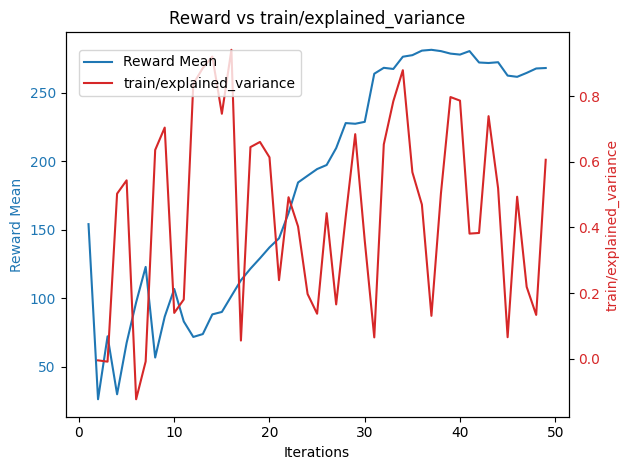

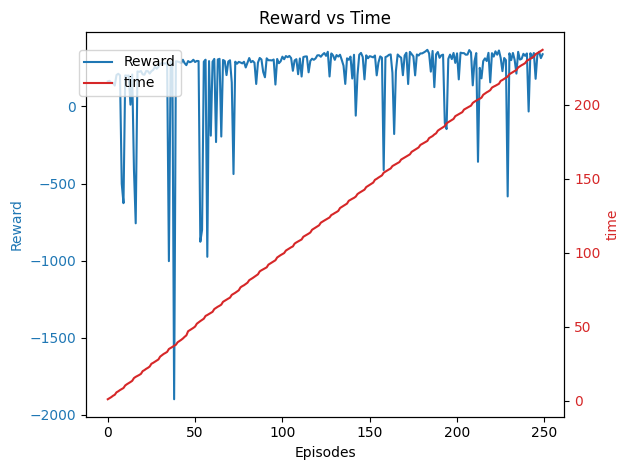

In [135]:
train_data_log: DataFrame = pd.read_csv(tmp_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(tmp_path+"monitor.csv",header=1)

#train_data_monitor = pd.concat([train_data_monitor] * 3, ignore_index=True)
print(train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
ax1.set_ylabel('Reward Mean', color='tab:blue')
ax1.plot(iterations, train_data_log['rollout/ep_rew_mean'], color='tab:blue', label='Reward Mean')
ax1.tick_params(axis='y', labelcolor='tab:blue')


col='train/explained_variance'

ax2 = ax1.twinx()
ax2.set_ylabel(col, color='tab:red')
ax2.plot(iterations, train_data_log[col], color='tab:red', label=col)
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_title('Reward vs '+col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes=range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Reward', color='tab:blue')
ax1.plot(episodes,train_data_monitor['r'], color='tab:blue', label='Reward')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
ax2.set_ylabel('time', color='tab:red')
ax2.plot(episodes,train_data_monitor['t'], color='tab:red', label='time')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


## Comprobación funcionamiento

In [156]:
seed = None
env = RouterEnv(seed=seed)
model = PPO.load(name, print_system_info=True)

num_steps = 1
obs, _ = env.reset()
# Variables de información:
acciones = []
rewards = []
ocu = []
tams = []
num = []
lim_ocu = 0
a2 = []

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)
        if len(ant)>0 and ant!=info:
            print(info["Stats"])
        ant=info


        ocu.append(info["Stats"]["OcupacionActual"])
        lim_ocu=info["Stats"]["LimiteOcupación"]
        tams.append(info["Stats"]["TamañoTotal"])
        num.append(info["Stats"]["NumPaquetes"])
        a2.append(info["Stats"]["Action"])
        
        rewards.append(reward)
        acciones.append(action.item())
        
        done: bool = done or terminated
        
    env.reset(seed=seed)
    step_counter += 1

# Debug
print(f"Acciones: {acciones}")
print(list(map(lambda x: Acciones.int_to_action(x), acciones)))
print(list(map(lambda x: int(round(x,0)), rewards)))
print(a2)


== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 0, 'TamañoTotal': 0.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.0, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 4, 'TamañoTotal': 402.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.016, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 7, 'TamañoTotal': 566.0, 'Action': <Acciones.PERMITIR: 1>, 'OcupacionActual': 0.028, 'LimiteOcupación': 0.8}
{'EstadoMaquina': 'EstadoAtaque', 'NumPaquetes': 10, 'TamañoTotal': 886.0, 'Action': <Acciones.PERMITI

In [157]:
assert len(acciones) != a2.count(Acciones.DENEGAR)
assert len(acciones) != a2.count(Acciones.PERMITIR)

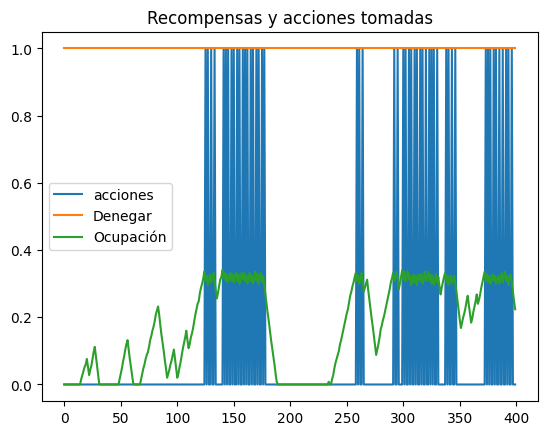

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, -0.1, 1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [158]:
assert len(acciones) == len(rewards)
#plt.plot(rewards, label="rewards")
plt.plot(acciones, label="acciones")

plt.plot([Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar")
plt.plot(ocu, label="Ocupación")
plt.title("Recompensas y acciones tomadas")

plt.legend()
plt.show()
print("Rewards: ",rewards)
num_permitidos = acciones.count(Acciones.action_to_int(Acciones.PERMITIR))
print(num_permitidos, len(acciones)-num_permitidos,"",num_permitidos/len(acciones),1-num_permitidos/len(acciones))

Ocupación:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.028, 0.04, 0.052, 0.06, 0.076, 0.052, 0.028, 0.044, 0.056, 0.076, 0.096, 0.112, 0.084, 0.056, 0.028, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.032, 0.048, 0.068, 0.084, 0.104, 0.12, 0.132, 0.104, 0.076, 0.052, 0.028, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.032, 0.048, 0.06, 0.076, 0.088, 0.096, 0.112, 0.132, 0.144, 0.16, 0.172, 0.188, 0.208, 0.22, 0.232, 0.208, 0.176, 0.148, 0.124, 0.1, 0.072, 0.048, 0.02, 0.032, 0.044, 0.06, 0.072, 0.088, 0.104, 0.076, 0.048, 0.02, 0.032, 0.052, 0.068, 0.088, 0.108, 0.124, 0.14, 0.16, 0.132, 0.108, 0.12, 0.14, 0.152, 0.168, 0.188, 0.208, 0.224, 0.24, 0.248, 0.272, 0.288, 0.3, 0.316, 0.336, 0.308, 0.324, 0.296, 0.312, 0.328, 0.304, 0.32, 0.332, 0.308, 0.28, 0.256, 0.272, 0.292, 0.312, 0.32, 0.34, 0.316, 0.332, 0.308, 0.328, 0.304, 0.316, 0.332, 0.308, 0.328, 0.304, 0.32, 0.332, 0.308, 0.328, 0.3

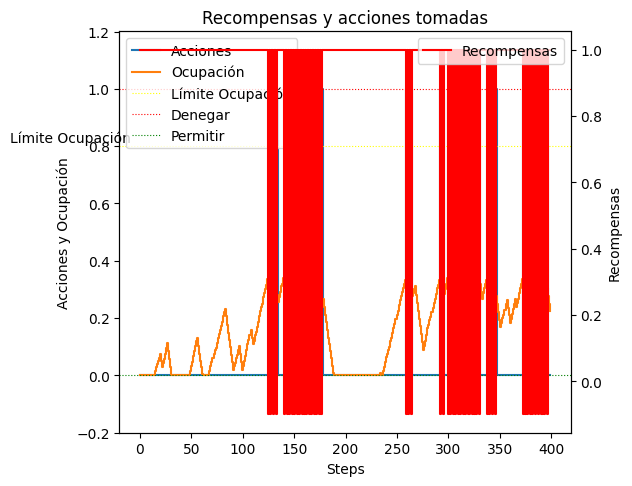

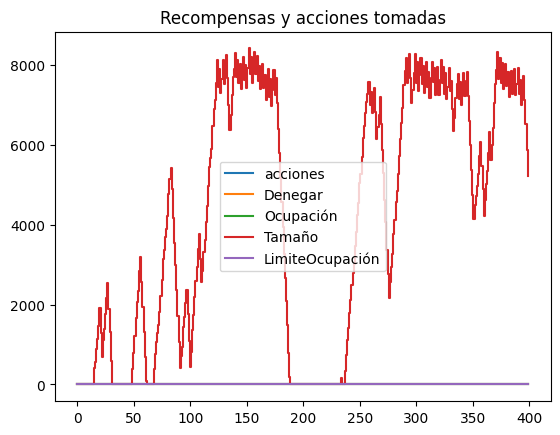

La ocupación máxima es de 34%
La ocupación máxima es de 0%


In [159]:
print("Ocupación: ",ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones, label="Acciones", where='post')
#ax1.step(range(len(acciones)), [1] * len(acciones), label="Denegar", where='mid')  # Ajustar según tus datos
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid')

# Crear línea horizontal en el gráfico
ax1.axhline(y=lim_ocu, color='yellow', linestyle='dotted', linewidth=0.8, label='Límite Ocupación')

# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales
if lim_ocu not in ticks:
    ticks.append(lim_ocu)  # Agregar el límite de ocupación a los ticks
ax1.set_yticks(sorted(ticks))  # Actualizar los ticks

# Anotar el límite en el eje
ax1.annotate(
    'Límite Ocupación', 
    xy=(-0.1, lim_ocu),  # Coordenada en el eje Y
    xytext=(-50, lim_ocu + 5), 
    textcoords='offset points',
    fontsize=10, color='black',
    ha='center',
    va='center'
)
ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red', linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR), color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards, label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam=[x/1 for x in tams]


plt.step(range(len(acciones)), acciones, label="acciones", where='mid')
plt.step(range(len(acciones)), [Acciones.action_to_int(Acciones.DENEGAR)]*len(acciones), label="Denegar", where='mid')
plt.step(range(len(ocu)),ocu, label="Ocupación",where='mid')
plt.step(range(len(tams)),tam, label="Tamaño",where='mid')

plt.plot([lim_ocu]*len(ocu), label="LimiteOcupación")

plt.title("Recompensas y acciones tomadas")
plt.legend()
plt.show()
print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación máxima es de {np.min(ocu):.0%}")

## Pruebas:

In [160]:
print(f"Tiempo medio: {tiempo_global/iteraciones if abs(iteraciones)>1e-5 else 0:.2f} micro-segundos de {iteraciones} iteraciones")

Tiempo medio: 0.00 micro-segundos de 0 iteraciones


In [161]:
print(Acciones.action_to_int(Acciones.PERMITIR))
print(Acciones.action_to_int(Acciones.DENEGAR))

0
1


['EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoAtaque', 'EstadoAtaque', 'EstadoAtaque', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'EstadoNormal', 'Estado

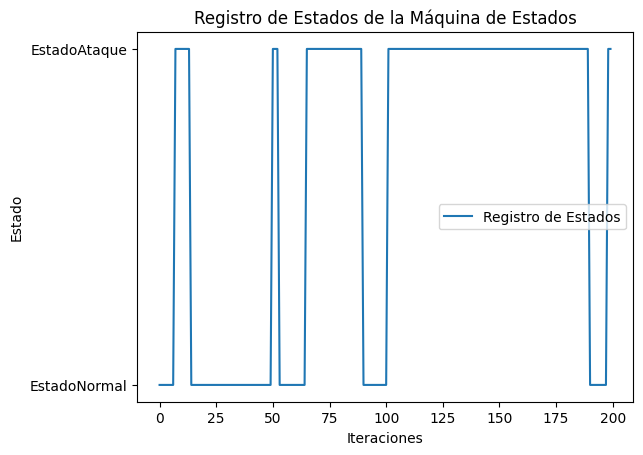

In [162]:
maquina = MaquinaDeEstados()
for _ in range(200):
    maquina.cambiar_estado()
print(maquina.registro_estados)

plt.plot(maquina.registro_estados, label="Registro de Estados")
plt.xlabel("Iteraciones")
plt.ylabel("Estado")
plt.title("Registro de Estados de la Máquina de Estados")
plt.legend()
plt.show()

In [163]:
# Lista de ejemplo
lista: list[str] = [x.__name__ for x in maquina.estados_posibles]
combinaciones_con_repeticion = list(product(lista, repeat=2))
dict_con: dict[tuple[str, str], int] = {x: 0 for x in combinaciones_con_repeticion}

print(dict_con)
duracion_ataques=[]
estado_Ant = maquina.registro_estados[0]

for estado in maquina.registro_estados[1:]:
    dict_con[(estado_Ant, estado)] += 1

    if (estado_Ant, estado) == (EstadoNormal.__name__, EstadoAtaque.__name__):  # Empieza ataque
        duracion_ataques.append(1)
    elif (estado_Ant, estado) == (EstadoAtaque.__name__, EstadoAtaque.__name__):  # Sigue ataque
        if len(duracion_ataques) > 0:
            duracion_ataques[-1] +=1

    estado_Ant: Estado = estado

print(f"Como promedio los {len(duracion_ataques)} ataques duran {np.mean(duracion_ataques):.1f} iteraciones.")
print("Duracion 5 primeros ataques: ",duracion_ataques[:5],"...")
try:
    for estado1 in lista:
        total = 0
        for estado2 in lista:
            total += dict_con[(estado1, estado2)]
        print(f"Estando en {estado1}:")
        for estado2 in lista:
            print(f"De {estado1} a {estado2}: {
                dict_con[(estado1, estado2)] / total:6.2%}")
except:
    pass

{('EstadoNormal', 'EstadoNormal'): 0, ('EstadoNormal', 'EstadoAtaque'): 0, ('EstadoAtaque', 'EstadoNormal'): 0, ('EstadoAtaque', 'EstadoAtaque'): 0}
Como promedio los 5 ataques duran 25.2 iteraciones.
Duracion 5 primeros ataques:  [7, 3, 25, 89, 2] ...
Estando en EstadoNormal:
De EstadoNormal a EstadoNormal: 93.24%
De EstadoNormal a EstadoAtaque:  6.76%
Estando en EstadoAtaque:
De EstadoAtaque a EstadoNormal:  3.20%
De EstadoAtaque a EstadoAtaque: 96.80%


In [164]:
_np_random, _ = seeding.np_random(None)
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=True))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
pak = []
for _ in range(1000):
    pak.append(_np_random.integers(1, 10, endpoint=False))

print(f"{np.min(pak)},{np.max(pak)},{np.mean(pak):.0f},{np.std(pak):.0f}")
print(type(0.0),type(0))
print(int(0.2))

1,10,6,3
1,9,5,3
<class 'float'> <class 'int'>
0


In [165]:
rate_al=seeding.np_random()[0].uniform(0.1,0.2)
print(rate_al)

0.17992698176133604
